# Week 13

## Parallel Programming

### Exercise 1) Analyzing Clock Solitare using Monte Carlo methods

Many problems may be difficult to analyze and explore in an exact and analytical way. In some cases, if computational power is avaiable and an exact solution is not nessecary(or possible), Monte Carlo methods may be a great way of exploring such systems. Often, Monte Carlo methods involves doing repeated "virtual experiments". A virtual experiment could involve giving some algorithm we would like to explore some random values to work on. We then do this repeatedly for different values. The heart of Monte Carlo(MC) lies in exploring the algorithm by interpreting the result of these virtual experiments, rather than analyzing the algorithm directly.

In this exercise, we will calculate the chance of winning a game of [Clock Solitare](https://en.wikipedia.org/wiki/Clock_Patience) using MC. Clock Solitare is 100% deterministic: the outcome is determined by the initial deck order. The rules are as follows:

![_](https://upload.wikimedia.org/wikipedia/commons/3/36/Clock_Solitaire.JPG) 

**Setup:**
Shuffle a deck of 52 cards. Split them up into 13 piles of 4 cards each. Place the piles according to each number on the clock, with the 13'th pile in the middle.

**How to play:**
Start by turning the top card of the 13'th pile face up. Take that card and place it face up under the pile that corresponds to its value(Ace $\rightarrow$ 1 O'clock, 2 $\rightarrow$ 2 O'clock, $\cdots$, Queen $\rightarrow$ 12 O'clock, King $\rightarrow$ Middle pile). Continue by turning the top card of the pile you just placed a card under, and repeat the processes.

**How to win:**
When unable to continue playing because you arrived at a pile containing no face down cards, you win if all cards have been turned face up. Oherwise, you lose.

#### Exercise 1a) Implementing the rules of the game.
Create a function `clock_solitare(deck)` that takes a shuffled list `deck` containing the usual 52 cards. The cards are only represented by their value, not their suit. For example, an ordered deck would be `deck = [1,1,1,1,2,2,2,2,3,...]`, where `1` corresponds to Ace. Jack, Queen and King corresponds to `11`, `12` and `13`. When called, the function should play a virtual game of Clock Solitude according to the rules described above. The function should return `True` if the particular deck order results in a win, otherwise it returns `False`.
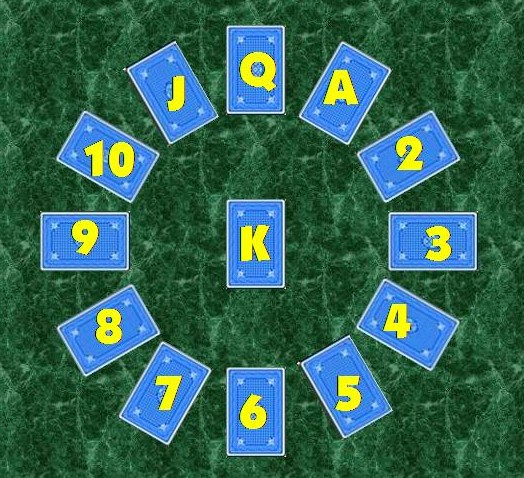

In [8]:
from numba import jit

def clock_solitare(deck):
    """Write fuction here
    """
    pass

Test:

In [9]:
import random
deck = 4*list(range(1,14))
expected = [False, False, False, True, True, False, False, False, False, False]
computed = []

random.seed(4)
for i in range(10):
    random.shuffle(deck)
    computed.append(clock_solitare(deck))
    
# assert computed == expected  # Uncomment this we you run the test

#### Exercise 1b) Implementing Monte Carlo

Create a function `monte_carlo_serial(game, N)` that takes a function `game` of the type you created in the previous exercise, and a number `N` indicating the number of runs to simulate. The function should call `game(deck)` N times, each time on a differently shuffled deck. Use the results to estimate the chance of winning a game of Clock Solitutde. Optimize the function using `jit()` and time how long it takes for $N = 10000$. For this rule set, the chance of winning happens to be exactly $\frac{1}{13}$.

In [10]:
import time

#### Exercise 1c) Using prange to parallelize MC
Write a function `monte_carlo_parallel(game, N)` using `prange`. Time it again still using $N = 10000$. How much is the speedup? If you are running on a very weak 2-core laptop, chances are you wont see a significant speedup. Test your code on a UiO-machine if you wish to.

#### Exercise 1d) Variation on Clock Solitare

We are going to implement a commom variation on the rules of Clock Solitare. In addition to the rules already stated, we are going to add one more condition:

If you would reveal the last face down card of a pile, and that card goes under the same pile it came from, start searching for a new pile by going clockwise(13'th pile moves to 1st). When you arrive at a pile with face down cards left, continue playing from this pile.

Modify `clock_solitare(deck)` so the new rule is implemented. Also feel free to add whatever rule you can think of yourself. By adding complicated rules, we are quickly moving towards a system that is progressivly more hopeless to be analyzed by analytical means, e.g. using combinatorics. However, Monte Carlo got our back and estimates the winning chance without breaking a sweat.

Rerun `monte_carlo_parallel` with the new rules. The winning chance should be around $10\%$ when implementing the proposed rule.

### Exercise 2) Parallelization of a double for-loop using Numba

Consider the following program

In [11]:
from numba import jit, prange
import numpy as np
import time

@jit()
def comp_serial(A):
    M, N = A.shape
    
    for i in range(1,M):
        for j in range(N):
            A[i,j] = A[i-1,j] + np.sin(j)
    
M = 100
N = 1000000
A = np.zeros((M,N))
A[0] = np.array(range(N))

start = time.time()
comp_serial(A)
end = time.time()

print(f"Time used: {end - start:.3}s")

#printing a slice of the matrix
print(A[-1,1:4])
print(A[-2,1:4])
print(A[-3,1:4])

Time used: 1.64s
[84.3056275  92.02044526 16.9708808 ]
[83.46415651 91.11114783 16.82976079]
[82.62268553 90.2018504  16.68864078]


In this code, we have defined a function `comp_serial` that takes a matrix `A` on which it does some calculations. The matrix has some initial condition stores in the first row, that is `A[0]`. The code has been optimized using `@jit()`, but is still a serial program.

Look at the implementation and get an overview of how the algorithm works. The expression encountered in the double for-loop is just some arbitrary computation for the sake of this exercise, and not something one would typically encounter in real applications. 

#### Exercise 2a) Parallelization using prange

Copy the implementation and rewrite it into a function `comp_parallel` that uses `prange` from numba to parallelize the double for-loop. Also copy the run example and compare output and runtime with the original implementation. Is the printed slice of the matrix the same? If not, why is this and how can we fix it?

*Hint:* If you are getting different values from the parallel version, try to think about what happens in the for-loop and about potensial *dependencies* in the calculation.

#### Exercise 2b) Testing the parallelized code on different M and N

We would like to test the correctly implemented parallel version for different values of $M$ and $N$. When looking at the double for-loop, one might see that the the complexity of the algorithm is $O(M\times N)$(try to argue why this is the case).

Try to decrease $N$ and increase $M$ such that $M\times N$ stays constant. Run the program for e.g. $M= 10^4, 10^5, 10^6$ and $N = 10^4, 10^3, 10^2$ and compare the different run times. Do you expect the time to increase/decrease/stay the same? Explain your results.

### Exercise 3) Parallel programming in C++ and avoiding race conditions

In this exercise, we want to create a C++ function that reads a text file and returns the number of occurences of a given letter. This is a task that is very parallelizable. 

#### Exercise 3a) Counting how often a letter appears in a string
Write a *serial* function `int count_letters(char* filename, char* letter)` that reads a textfile `filename` and counts the number of times `letter` occurs in the file. Finally, the function returns this number. For the sake of simplicity, assume the textfile consists of a single line consisting of the characters A, B, C, D and E. 

*Hint:* Reading files can be a bit bothersome in C++, but is a worthwhile thing to learn. There are several ways to do it, but a popular choice is to use the packages `<fstream>` and `<string>`. You will need to declare an object `ifstream myfile(filename)`, where `myfile` is just an arbitrary naming convention. This is equivalent to Python's `myfile = open(filename,"r")`. Much like in python, the file is read one line at a time. Declare a variable `string line`. To get the first line, we simply call `getline(myfile, line)`. From here, you can iterate over `line` using a for-loop.

#### Exercise 3b) Counting in parallel using private variables. 
Next, we would like to parallelize the function using `omp` directives on the for-loop. This would then give hints to the compiler that it should split the for-loop between the available threads, much like numbas prange.  

*Hint:* A naïve implementation of `omp` directives will most likely cause a race condition in this particular code, because all the threads are trying to increment the same variable when counting the letters. This causes a race condition(why?), but can be fixed by using two additional directive form OpenMP:

`firstprivate(num_letter)`, where `num_letters` is the name of the variable you use to count the number of times a letter is found. When you include this directive in addition to the others before a for-loop, it makes `num_letter` private, meaning each threads gets a local copy only they can change. 

This removes the race condition, but leaves us having many private `num_letter` that each account for just a fraction of the total number of letters. We need to somehow sum all the copies of `num_letter` into `total_num_letter`. The solution is to make a `critical` region after the for-loop.

A critical region is established as such:
```Cpp

#pragma omp parallel critical
{
.
.
.
}
```
When the previous team of threads generated by the for-loop reaches this region, only one thread may enter at a time, and the others must wait outside until the current thread is done. This mean whatever happens in the critical region, a race condition will never occur.

Make a critcal region after the for-loop where you sum all the local copies of `num_letter`. What would happen if we removed the `critical` directive?

#### Exercise 3c) The smarter way with `reduction(+:var)`

The previous way of summing in parallel is just fine, but the implementation is a bit involved given that this is a problem one encounters very often. Likewise, OpenMP have implemented another directive that lets us skip `firstprivate` and `critical` all together. Adding `reduction(+:num_letter)` to the usual for-loop directives does everything we want. First, it makes `num_letters` private. Then, the argument `+` indicates that the private variables shall be all summed at the end.

Change the program to use `reduction` rather that `firstprivate` and `critical`

### Exercise 4) Brute force optimization

A typically problem arising in scientific computing is minimization of some function of your input parameters. For example you can can have a function that represents the misfit between your model and data. Say that you have an ODE describing some some physical phenomena and some data that you want to fit to that model. Then you could try different parameters in your model and see which one that best describes your data. 

In this exercise we will only try to find the miniumun of the [Ackley function](https://en.wikipedia.org/wiki/Ackley_function) by only sampling the parameter space. The Ackley function is a special function that is considered difficult to minimize and is used as a [test function for optimization algorithms](https://en.wikipedia.org/wiki/Test_functions_for_optimization). It has a global minimium at $(x, y) = (0,0)$, but it has also several local minima.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

def func(x, y):
    return -20 * np.exp(-0.2 * np.sqrt( 0.5 * (x**2 + y**2))) - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) + np.exp(1) + 20

To see that this is a difficult function to minimize we can try one one the standard minimization methods from [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

In [13]:
from scipy.optimize import minimize
f = lambda x: func(*x)
res = minimize(f, x0=(1, 3), method='Nelder-Mead')
print(res)

final_simplex: (array([[0.98919676, 2.96726684],
       [0.9891011 , 2.96725987],
       [0.98914394, 2.96733776]]), array([7.1809517 , 7.18095172, 7.18095181]))
           fun: 7.180951697166183
       message: 'Optimization terminated successfully.'
          nfev: 48
           nit: 25
        status: 0
       success: True
             x: array([0.98919676, 2.96726684])


The global mimnimum value is at (0.0), but you will see that the results will heavily depend on the initiatial starting point ($x_0$). A more robust approach is to simply loop over all possible values and keep track of the minimum value.

#### Exercise 4a)
Plot the Ackley function surface for $x, y \in [-5, 5]$. 

#### Execerices 4b)
Implement a function that loops over a uniform grid for $x, y \in [-5, 5]$, and find the minimum of the Ackley function. Choose appropriate grid size and compute the time it takes to find the minimum.

#### Execercise 4c)
Split the grid into smaller subgrids and apply the brute force method by looping over the points on each subgrid on different processes. Estimate the time it takes to run the program and compare with the serial version.